In [4]:
from ase.io import read
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os

from glob import glob
from mlptools.atoms.extract_atoms import extract_atoms

## LAMMPSのdumpファイルから入射直後の構造を取得する

In [83]:
path2dump = '/Users/y1u0d2/desktop/Lab/result/lammps/Si/sputtering/ml/depth15/0deg_1000eV/dump.lammpstrj'
# atoms = read(path2dump, index=0, format='lammps-dump-text')

In [84]:
from ovito.io import import_file
from ovito.io.ase import ovito_to_ase

# Import a sequence of files.
pipeline = import_file(path2dump)

In [85]:
import random
random.seed(1)

dump_structure_every_n_steps = 500
insert_atom_every_n_steps = 20000
n_frame_after_insertion = 3

insert_atom_every_n_frames = insert_atom_every_n_steps // dump_structure_every_n_steps
pipeline.source.num_frames, insert_atom_every_n_frames

insert_atom_frame_idx_list = [i * insert_atom_every_n_frames + 1 for i in range(pipeline.source.num_frames // insert_atom_every_n_frames)]
for i in range(1, n_frame_after_insertion):
    insert_atom_frame_idx_list_plus = [idx + i for idx in insert_atom_frame_idx_list]
    insert_atom_frame_idx_list += insert_atom_frame_idx_list_plus
insert_atom_frame_idx_list.sort()

# get some elements from list randomly
random_idx_list = random.sample(range(len(insert_atom_frame_idx_list)), 10)
random_idx_list.sort()
random_insert_atom_frame_idx_list = [insert_atom_frame_idx_list[idx] for idx in random_idx_list]
# ase_atoms_list = []

In [89]:
# Loop over all frames of the sequence.
path2save = "/Users/y1u0d2/desktop/Lab/result/lammps/Si/sputtering/ml/depth15/0deg_1000eV/atoms"
for frame_index in random_insert_atom_frame_idx_list:
    filename = f'frame{frame_index}.pkl'
    data = pipeline.source.compute(frame_index)
    ase_atoms = ovito_to_ase(data)

    print('Frame source:', data.attributes['SourceFile'])
    print('Frame index:', data.attributes['SourceFrame'])

    with open(os.path.join(path2save, filename), 'wb') as f:
        pickle.dump(ase_atoms, f)
    # break

Frame source: /Users/y1u0d2/desktop/Lab/result/lammps/Si/sputtering/ml/depth15/0deg_1000eV/dump.lammpstrj
Frame index: 2563
Frame source: /Users/y1u0d2/desktop/Lab/result/lammps/Si/sputtering/ml/depth15/0deg_1000eV/dump.lammpstrj
Frame index: 4803
Frame source: /Users/y1u0d2/desktop/Lab/result/lammps/Si/sputtering/ml/depth15/0deg_1000eV/dump.lammpstrj
Frame index: 5483
Frame source: /Users/y1u0d2/desktop/Lab/result/lammps/Si/sputtering/ml/depth15/0deg_1000eV/dump.lammpstrj
Frame index: 10441
Frame source: /Users/y1u0d2/desktop/Lab/result/lammps/Si/sputtering/ml/depth15/0deg_1000eV/dump.lammpstrj
Frame index: 20282
Frame source: /Users/y1u0d2/desktop/Lab/result/lammps/Si/sputtering/ml/depth15/0deg_1000eV/dump.lammpstrj
Frame index: 23284
Frame source: /Users/y1u0d2/desktop/Lab/result/lammps/Si/sputtering/ml/depth15/0deg_1000eV/dump.lammpstrj
Frame index: 31161
Frame source: /Users/y1u0d2/desktop/Lab/result/lammps/Si/sputtering/ml/depth15/0deg_1000eV/dump.lammpstrj
Frame index: 31281
Fra

# ASE Atoms objectから特定の範囲の原子を取り出す

In [94]:
# load pickle file
path2atoms = "/Users/y1u0d2/desktop/Lab/result/lammps/Si/sputtering/ml/depth15/0deg_1000eV/atoms"
with open(os.path.join(path2atoms, 'frame10441.pkl'), 'rb') as f:
    atoms = pickle.load(f)

(100.0, 149.325)

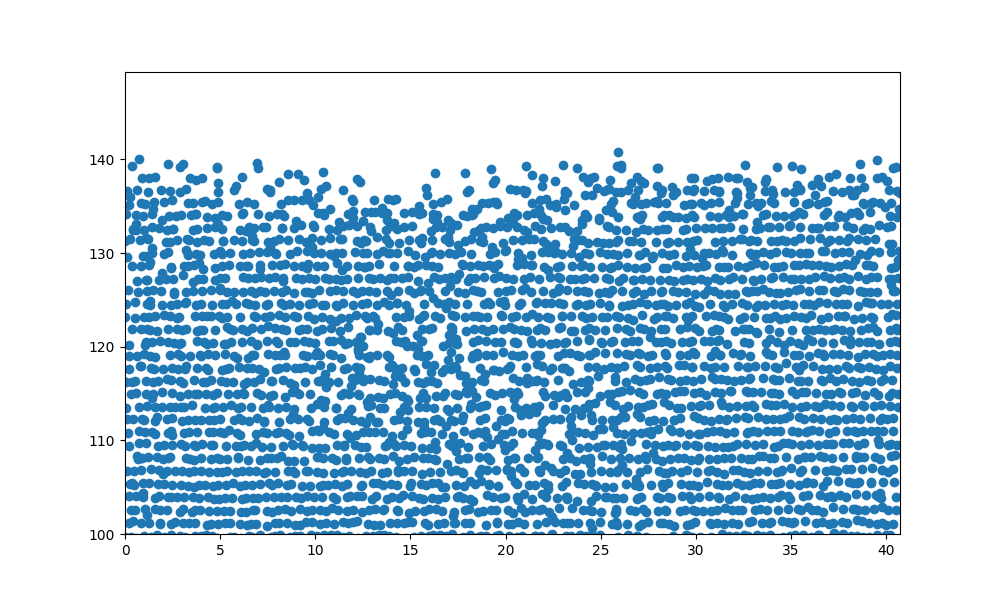

In [96]:
# atoms = ase_atoms_list[0]
coord = atoms.get_positions()
cell = atoms.get_cell()

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

ax.scatter(coord[:, 0], coord[:, 2])
ax.set_xlim(0, cell[0].max())
ax.set_ylim(100, cell[2].max())

In [100]:
from mlptools.atoms.extract_atoms import extract_atoms

# extract atoms on the given range
x_range = [10, 20]
y_range = [20, 30]
z_range = [120, 149.325]
extracted_atoms = extract_atoms(atoms, x_range, y_range, z_range)

In [5]:
path2save = "/Users/y1u0d2/desktop/Lab/result/lammps/Si/sputtering/ml/depth15/0deg_1000eV/surface_atoms"
x_range_list = [[0, 10], [10, 20], [20, 30], [30, 40]]
y_range_list = [[0, 10], [10, 20], [20, 30], [30, 40]]
z_range = [120, 149.325]

range_combination = []
for x_range in x_range_list:
    for y_range in y_range_list:
        range_combination.append([x_range, y_range, z_range])

def random_str(length):
    import random
    import string
    return ''.join(random.choice(string.ascii_letters) for i in range(length))

for x_range, y_range, z_range in range_combination:
    extracted_atoms = extract_atoms(atoms, x_range, y_range, z_range)
    # save atoms
    filename = f'{random_str(50)}.pkl'
    with open(os.path.join(path2save, filename), 'wb') as f:
        pickle.dump(extracted_atoms, f)

In [7]:
path2atoms = "/Users/y1u0d2/desktop/Lab/result/lammps/Si/sputtering/ml/depth15/0deg_1000eV/atoms"
atoms_files = glob(os.path.join(path2atoms, '*.pkl'))
print(len(atoms_files))

10


In [10]:
path2save = "/Users/y1u0d2/desktop/Lab/result/lammps/Si/sputtering/ml/depth15/0deg_1000eV/surface_atoms"
x_range_list = [[0, 10], [10, 20], [20, 30], [30, 40]]
y_range_list = [[0, 10], [10, 20], [20, 30], [30, 40]]
z_range = [120, 149.325]

range_combination = []
for x_range in x_range_list:
    for y_range in y_range_list:
        range_combination.append([x_range, y_range, z_range])


for atoms_f in atoms_files:
    frame_name = atoms_f.split('/')[-1].split('.')[0]
    print(frame_name)
    with open(atoms_f, 'rb') as f:
        atoms = pickle.load(f)
    print(len(atoms))

    for x_range, y_range, z_range in range_combination:
        extracted_atoms = extract_atoms(atoms, x_range, y_range, z_range)
        # save atoms
        filename = f'{frame_name}_x{x_range[0]}-{x_range[1]}_y{y_range[0]}-{y_range[1]}_z{z_range[0]}-{z_range[1]}.pkl'
        print(filename)
        with open(os.path.join(path2save, filename), 'wb') as f:
            pickle.dump(extracted_atoms, f)
    # break

frame34684
11497
frame34684_x0-10_y0-10_z120-149.325.pkl
frame34684_x0-10_y10-20_z120-149.325.pkl
frame34684_x0-10_y20-30_z120-149.325.pkl
frame34684_x0-10_y30-40_z120-149.325.pkl
frame34684_x10-20_y0-10_z120-149.325.pkl
frame34684_x10-20_y10-20_z120-149.325.pkl
frame34684_x10-20_y20-30_z120-149.325.pkl
frame34684_x10-20_y30-40_z120-149.325.pkl
frame34684_x20-30_y0-10_z120-149.325.pkl
frame34684_x20-30_y10-20_z120-149.325.pkl
frame34684_x20-30_y20-30_z120-149.325.pkl
frame34684_x20-30_y30-40_z120-149.325.pkl
frame34684_x30-40_y0-10_z120-149.325.pkl
frame34684_x30-40_y10-20_z120-149.325.pkl
frame34684_x30-40_y20-30_z120-149.325.pkl
frame34684_x30-40_y30-40_z120-149.325.pkl
frame4803
11289
frame4803_x0-10_y0-10_z120-149.325.pkl
frame4803_x0-10_y10-20_z120-149.325.pkl
frame4803_x0-10_y20-30_z120-149.325.pkl
frame4803_x0-10_y30-40_z120-149.325.pkl
frame4803_x10-20_y0-10_z120-149.325.pkl
frame4803_x10-20_y10-20_z120-149.325.pkl
frame4803_x10-20_y20-30_z120-149.325.pkl
frame4803_x10-20_y30-4